In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format
from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.ar_model import AutoReg
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('M2SLMoneyStock.csv')
data.head()

,Date,Money
0,1/1/1995,3492.40
1,2/1/1995,3489.90
2,3/1/1995,3491.10
3,4/1/1995,3499.20
4,5/1/1995,3524.20


In [3]:
len(data)

252

In [4]:
data = data.set_index('Date')
data.head()

,Money
Date,
1/1/1995,3492.40
2/1/1995,3489.90
3/1/1995,3491.10
4/1/1995,3499.20
5/1/1995,3524.20


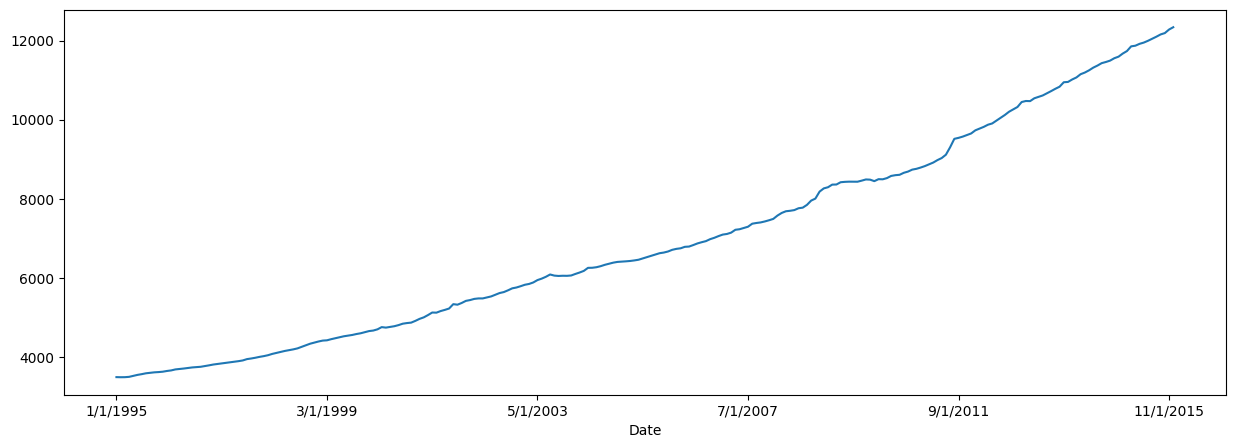

In [5]:
plt.figure(figsize = (15,5))
data['Money'].plot();

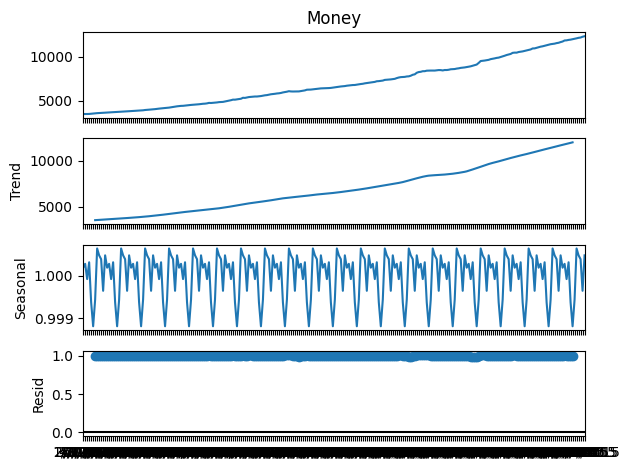

In [6]:
dec = sm.tsa.seasonal_decompose(data['Money'],period = 12, model = 'multiplicative').plot()
plt.show()

In [7]:
### ADF test

def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

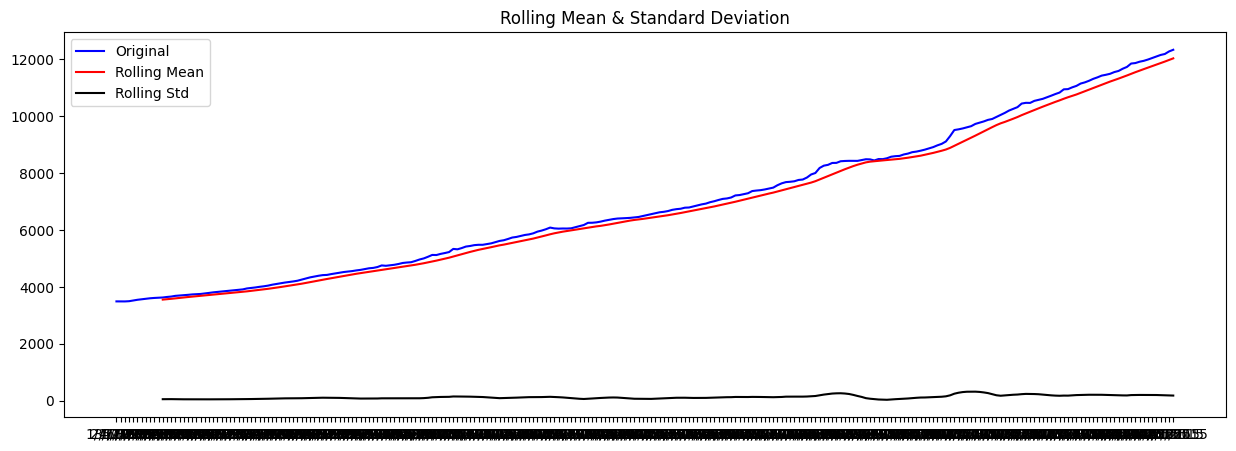

Results of Dickey-Fuller Test:
Test Statistic                  4.24
p-value                         1.00
#Lags Used                      4.00
Number of Observations Used   247.00
Critical Value (1%)            -3.46
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


In [8]:
test_stationarity(data['Money'])

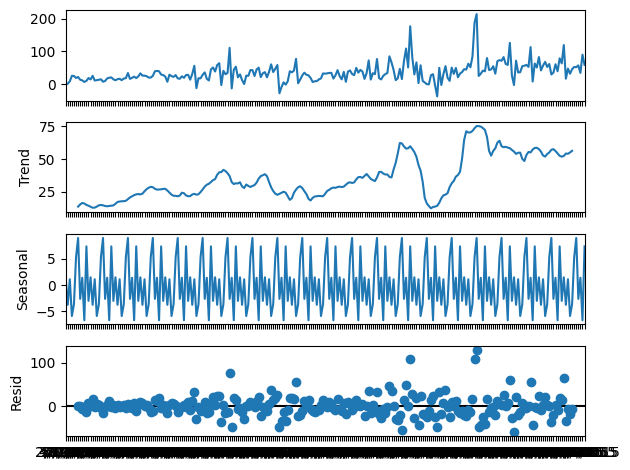

In [9]:
data_diff = data.diff()
data_diff = data_diff.dropna()

dec = sm.tsa.seasonal_decompose(data_diff,period = 12).plot()
plt.show()

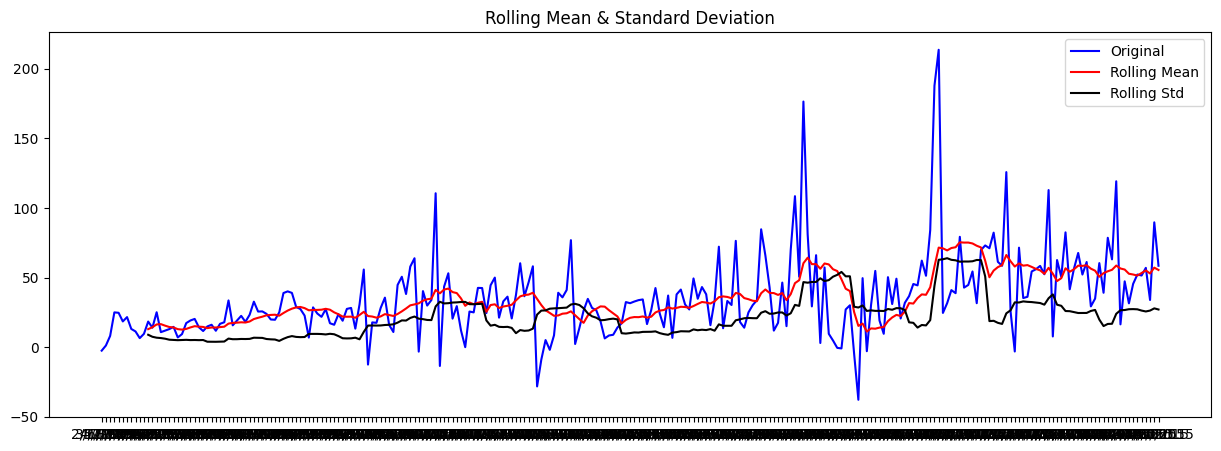

Results of Dickey-Fuller Test:
Test Statistic                 -2.06
p-value                         0.26
#Lags Used                     15.00
Number of Observations Used   235.00
Critical Value (1%)            -3.46
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


In [10]:
test_stationarity(data_diff)

In [11]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

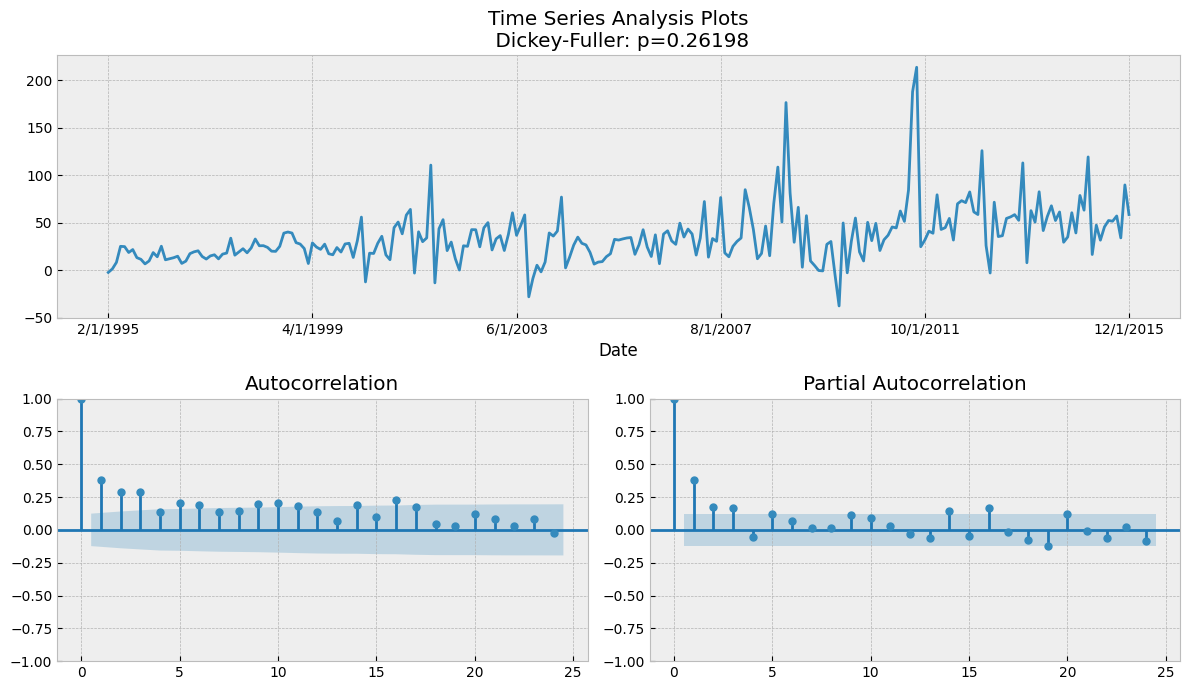

In [12]:
tsplot(data_diff['Money'])

In [13]:
size = int(len(data) - 30)
train, test = data['Money'][0:size], data['Money'][size:len(data)]

### P = 3
### Q = 3
### D = 1


## AR model

In [14]:
# Fit an autoregressive model
model = AutoReg(data['Money'], lags=3)
results = model.fit()

# Access coefficients
coefficients = results.params

# Access the residual standard error
residual_std_error = results.scale

# Access fitted values
fitted_values = results.fittedvalues

# Access AIC and BIC
aic = results.aic
bic = results.bic

# Print the coefficients and other information
print("Coefficients:", coefficients)
print("Residual Standard Error:", residual_std_error)
print("AIC:", aic)
print("BIC:", bic)

Coefficients: const       0.70
Money.L1    1.22
Money.L2   -0.13
Money.L3   -0.08
dtype: float64
Residual Standard Error: 684.5381868822525
AIC: 2342.2887528964943
BIC: 2359.876017378818


In [15]:
# Predict future values
predictions = results.predict(start=size, end=len(data), dynamic=False)

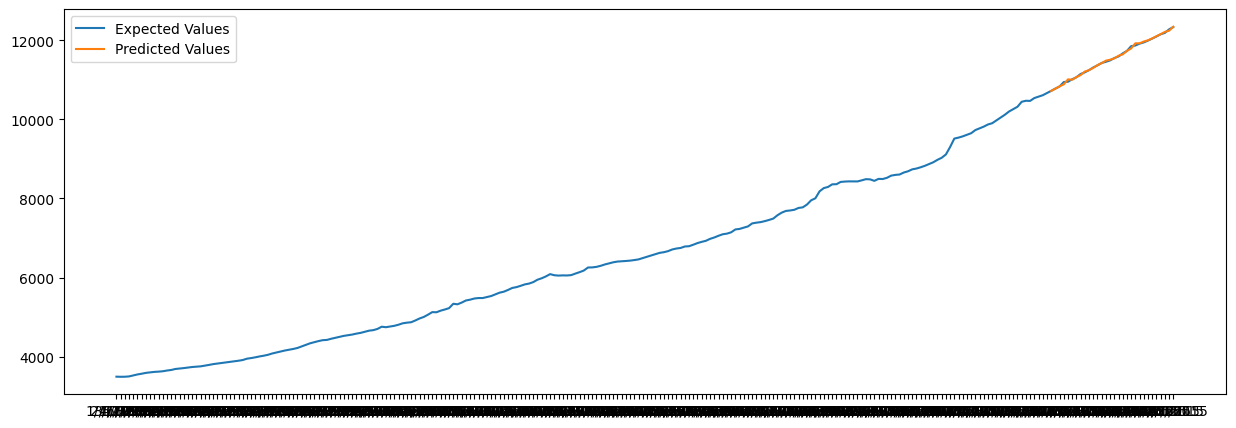

In [16]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(data['Money'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

### ARIMA Model

In [17]:
model = ARIMA(train,order = (3,1,3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Money   No. Observations:                  222
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1034.980
Date:                Sat, 08 Jun 2024   AIC                           2083.961
Time:                        10:26:37   BIC                           2107.748
Sample:                    01-01-1995   HQIC                          2093.566
                         - 06-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7118      0.057    -12.481      0.000      -0.824      -0.600
ar.L2          0.8918      0.029     30.499      0.000       0.835       0.949
ar.L3          0.7843      0.053     14.682      0.0

In [18]:
# Predict future values
forecast = results.forecast(steps=30)

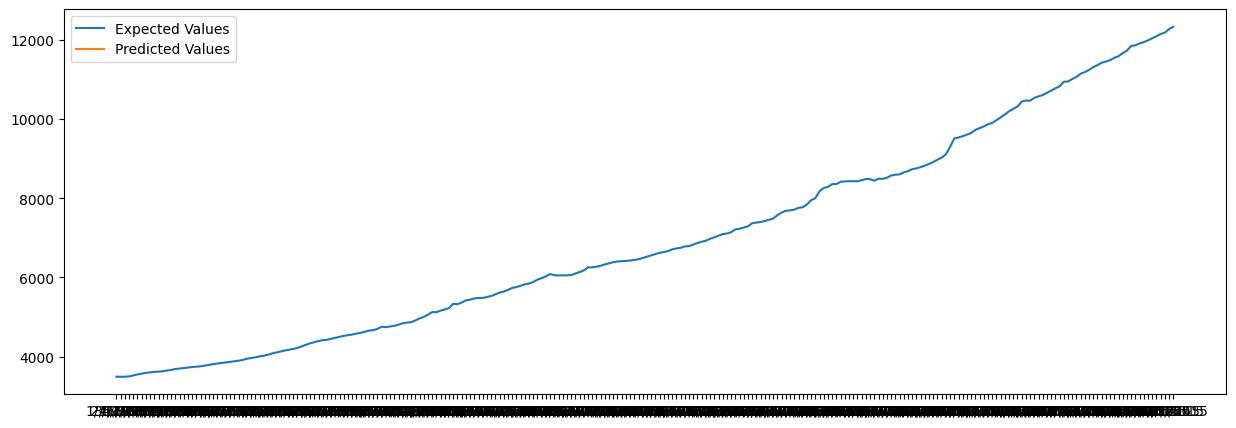

In [19]:
predictions_series = pd.Series(forecast, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(data['Money'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

### SARIMAX Model

In [20]:
# Fit a SARIMAX model
model = SARIMAX(train, order=(3, 1, 3), seasonal_order=(0, 1, 1, 12))
results = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.55668D+00    |proj g|=  3.42281D-02

At iterate    5    f=  4.54720D+00    |proj g|=  2.26410D-02


 This problem is unconstrained.



At iterate   10    f=  4.53090D+00    |proj g|=  8.07017D-02

At iterate   15    f=  4.49505D+00    |proj g|=  7.32811D-02

At iterate   20    f=  4.48102D+00    |proj g|=  2.72652D-02

At iterate   25    f=  4.47983D+00    |proj g|=  1.04190D-02

At iterate   30    f=  4.47961D+00    |proj g|=  3.54496D-03

At iterate   35    f=  4.47864D+00    |proj g|=  1.42223D-02

At iterate   40    f=  4.47716D+00    |proj g|=  1.22347D-02

At iterate   45    f=  4.47654D+00    |proj g|=  2.69445D-03

At iterate   50    f=  4.47652D+00    |proj g|=  8.62490D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63   